In [10]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Install PySpark if not already installed
!pip install pyspark

# Import SparkSession and create a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()

file_path = "/content/HeartDiseaseTrain-Test.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [11]:
# Tampilkan skema untuk memahami tipe data
df.printSchema()

# Tampilkan statistik dasar
df.describe().show()

# Periksa nilai yang hilang di setiap kolom
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Tampilkan beberapa baris pertama DataFrame
df.show()

# Konversi ke Pandas DataFrame untuk visualisasi yang lebih mudah dengan Seaborn/Matplotlib
pandas_df = df.toPandas()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- chest_pain_type: string (nullable = true)
 |-- resting_blood_pressure: integer (nullable = true)
 |-- cholestoral: integer (nullable = true)
 |-- fasting_blood_sugar: string (nullable = true)
 |-- rest_ecg: string (nullable = true)
 |-- Max_heart_rate: integer (nullable = true)
 |-- exercise_induced_angina: string (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: string (nullable = true)
 |-- vessels_colored_by_flourosopy: string (nullable = true)
 |-- thalassemia: string (nullable = true)
 |-- target: integer (nullable = true)

+-------+-----------------+------+---------------+----------------------+-----------------+--------------------+--------------------+------------------+-----------------------+------------------+-----------+-----------------------------+-----------------+------------------+
|summary|              age|   sex|chest_pain_type|resting_blood_pressure|      cholestoral

+---+---+---------------+----------------------+-----------+-------------------+--------+--------------+-----------------------+-------+-----+-----------------------------+-----------+------+
|age|sex|chest_pain_type|resting_blood_pressure|cholestoral|fasting_blood_sugar|rest_ecg|Max_heart_rate|exercise_induced_angina|oldpeak|slope|vessels_colored_by_flourosopy|thalassemia|target|
+---+---+---------------+----------------------+-----------+-------------------+--------+--------------+-----------------------+-------+-----+-----------------------------+-----------+------+
|  0|  0|              0|                     0|          0|                  0|       0|             0|                      0|      0|    0|                            0|          0|     0|
+---+---+---------------+----------------------+-----------+-------------------+--------+--------------+-----------------------+-------+-----+-----------------------------+-----------+------+

Jumlah data duplikat: 723
Jumlah data d

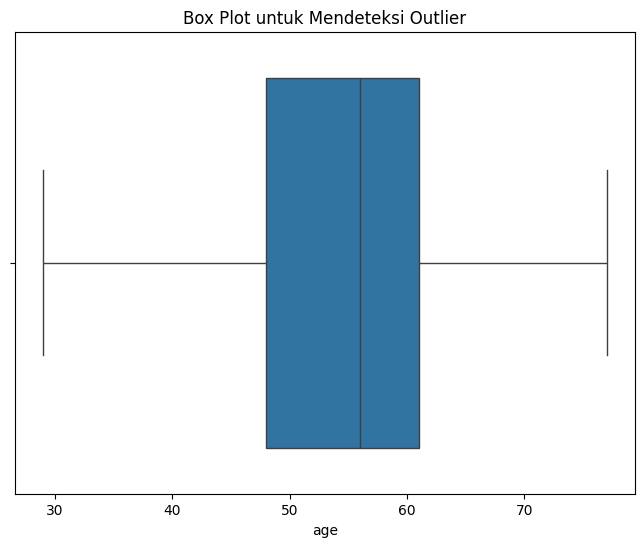

In [12]:
#Periksa Nilai yang Hilang
from pyspark.sql.functions import isnan, when, count, col
missing_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

#Periksa Data Duplikat
duplicate_count = df.count() - df.distinct().count()
print(f"Jumlah data duplikat: {duplicate_count}")

#Periksa Konsistensi Data
#Untuk kolom 'age', kita bisa periksa apakah ada nilai yang tidak masuk akal
invalid_age_count = df.filter( (df["Age"] < 0) | (df["Age"] > 120) ).count()
print(f"Jumlah data dengan usia tidak valid: {invalid_age_count}")

#Periksa Outlier (Data Pencilan)
#Menggunakan visualisasi seperti box plot (dengan Pandas DataFrame)
pandas_df = df.toPandas()
plt.figure(figsize=(8, 6))
sns.boxplot(x=pandas_df['age'])
plt.title('Box Plot untuk Mendeteksi Outlier')
plt.show()

In [13]:
print(pandas_df.describe())

               age  resting_blood_pressure  cholestoral  Max_heart_rate  \
count  1025.000000             1025.000000   1025.00000     1025.000000   
mean     54.434146              131.611707    246.00000      149.114146   
std       9.072290               17.516718     51.59251       23.005724   
min      29.000000               94.000000    126.00000       71.000000   
25%      48.000000              120.000000    211.00000      132.000000   
50%      56.000000              130.000000    240.00000      152.000000   
75%      61.000000              140.000000    275.00000      166.000000   
max      77.000000              200.000000    564.00000      202.000000   

           oldpeak       target  
count  1025.000000  1025.000000  
mean      1.071512     0.513171  
std       1.175053     0.500070  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.800000     1.000000  
75%       1.800000     1.000000  
max       6.200000     1.000000  


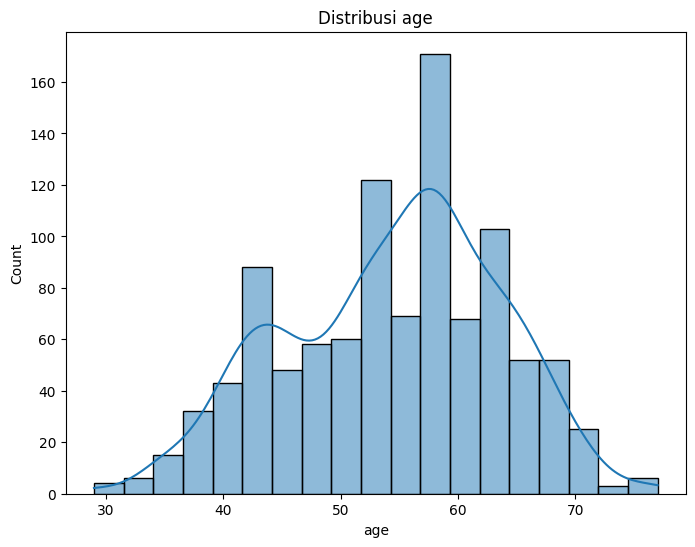

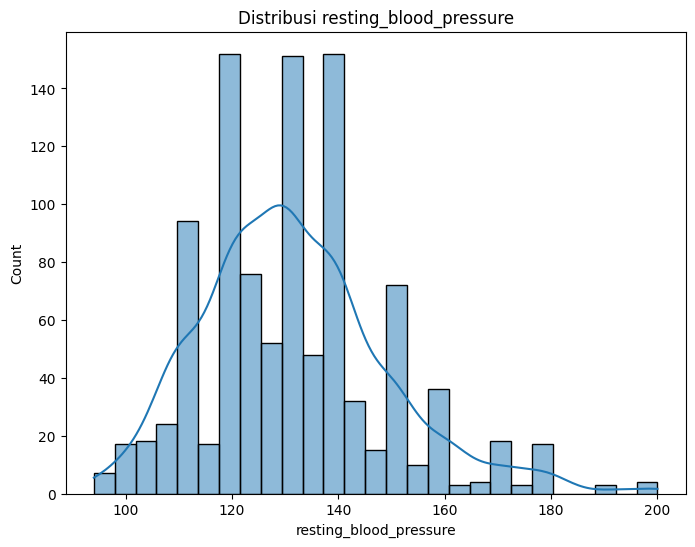

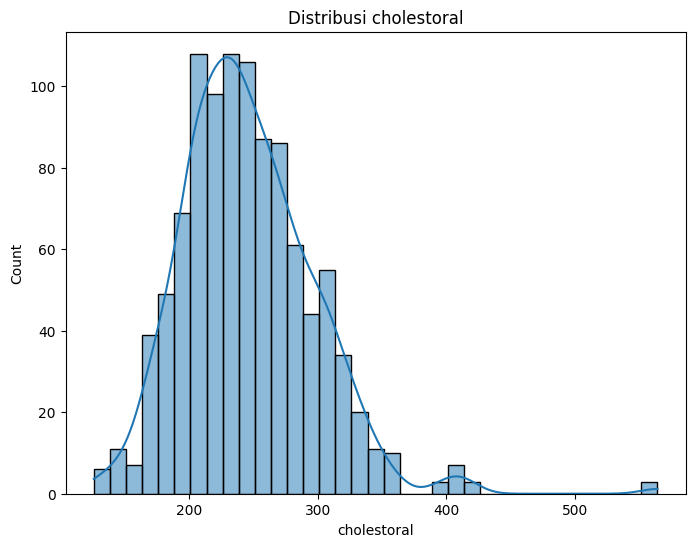

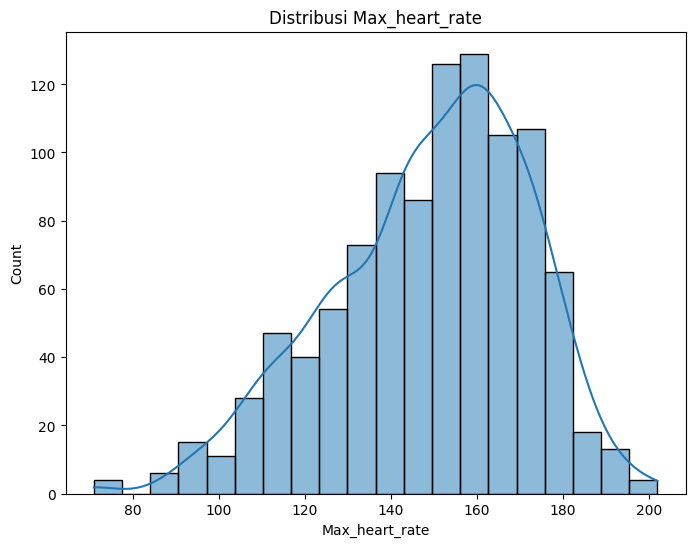

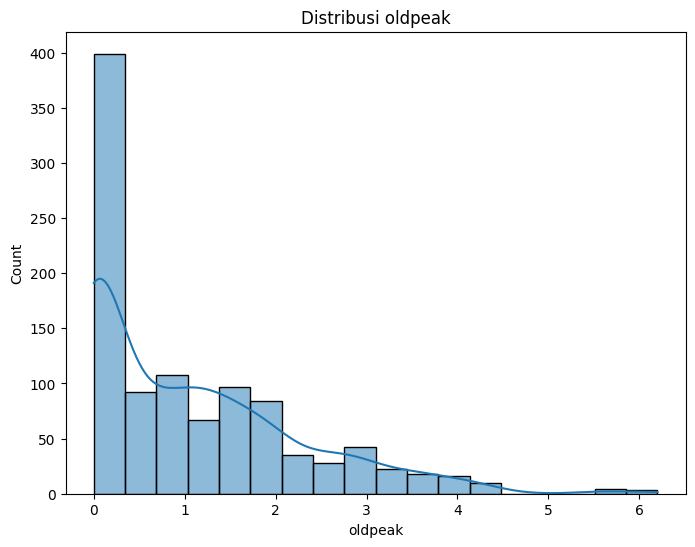

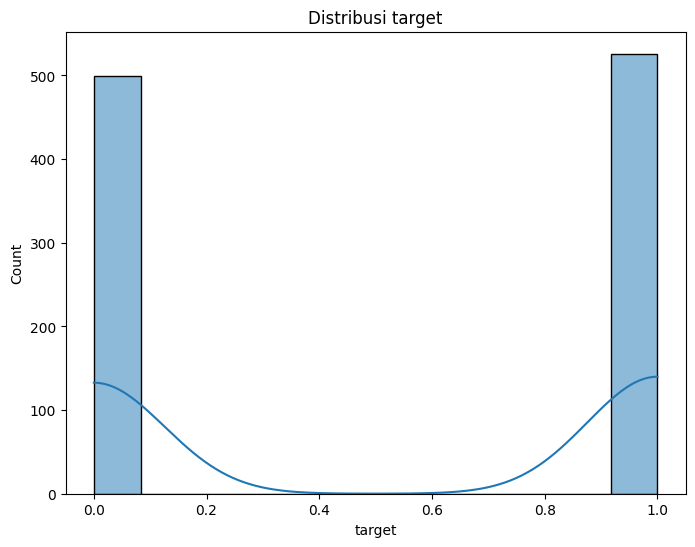

In [14]:
for col in pandas_df.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(pandas_df[col], kde=True)
    plt.title(f'Distribusi {col}')
    plt.show()

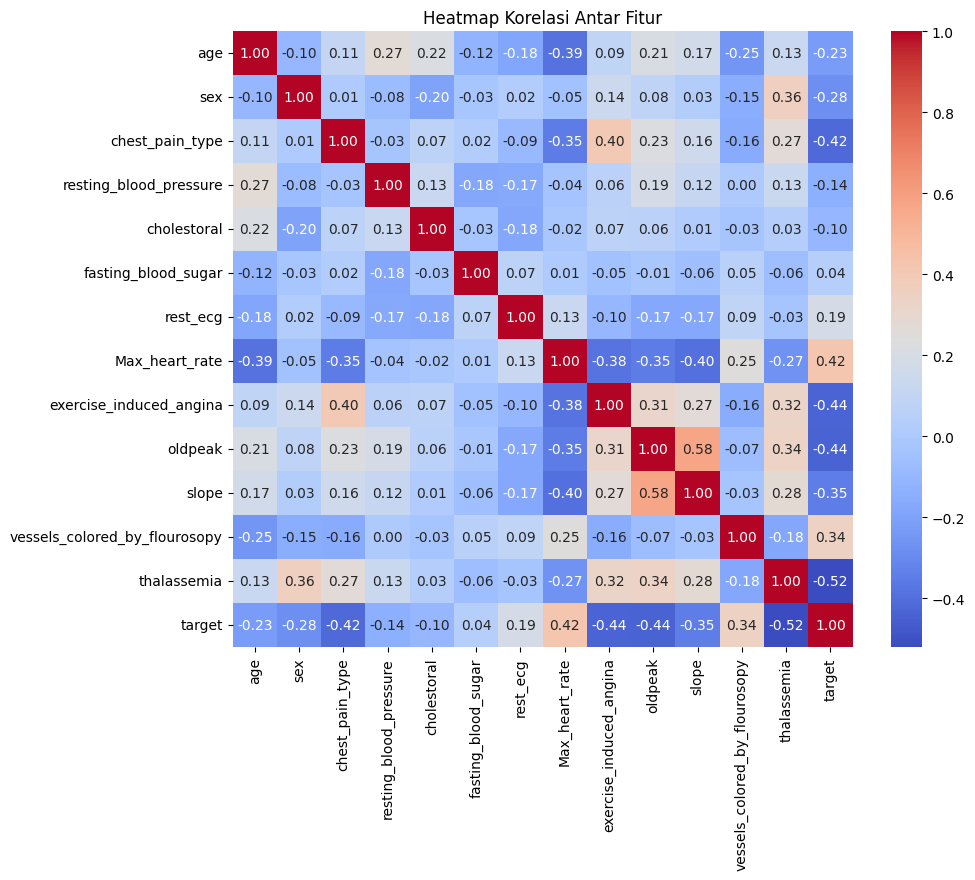

In [15]:
for column in pandas_df.select_dtypes(include=['object']).columns:
    pandas_df[column] = pandas_df[column].astype('category').cat.codes

plt.figure(figsize=(10, 8))
sns.heatmap(pandas_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()

In [25]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Pisahkan fitur (X) dan target (y)
X = pandas_df.drop('target', axis=1)
y = pandas_df['target']

# Ubah fitur kategorikal menjadi numerik (jika ada)
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])

# Lakukan penskalaan fitur
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Buat model Logistic Regression
model = LogisticRegression(max_iter=1000)

# Buat objek RFE dengan 5 fitur yang akan dipilih
rfe = RFE(estimator=model, n_features_to_select=5)

# Latih RFE pada data
rfe.fit(X, y)

# Dapatkan fitur-fitur yang terpilih
selected_features = pandas_df.drop('target', axis=1).columns[rfe.support_]

# Tampilkan fitur-fitur yang terpilih
print(f"Fitur yang terpilih: {selected_features.tolist()}")

Fitur yang terpilih: ['chest_pain_type', 'exercise_induced_angina', 'oldpeak', 'vessels_colored_by_flourosopy', 'thalassemia']


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

# Pisahkan fitur (X) dan target (y)
X = pandas_df.drop('target', axis=1)
y = pandas_df['target']

for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Inisialisasi model Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Latih model
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [19]:
from sklearn.metrics import accuracy_score, classification_report

# Prediksi pada data uji
y_pred = gb_model.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi: {accuracy}")

# Tampilkan laporan klasifikasi
print(classification_report(y_test, y_pred))

Akurasi: 0.9365853658536586
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       102
           1       0.93      0.94      0.94       103

    accuracy                           0.94       205
   macro avg       0.94      0.94      0.94       205
weighted avg       0.94      0.94      0.94       205



In [20]:
y_pred = gb_model.predict(X_test)
y_prob = gb_model.predict_proba(X_test)[:, 1]

##Confusion Matrix

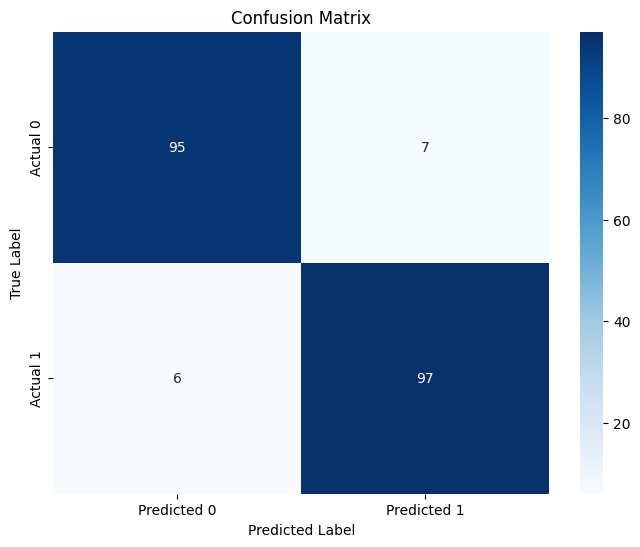

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##ROC Curve

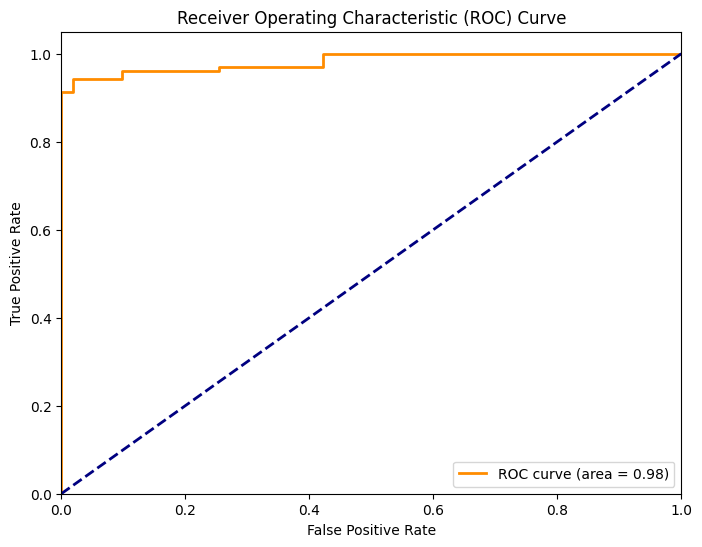

In [22]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Feature Importance

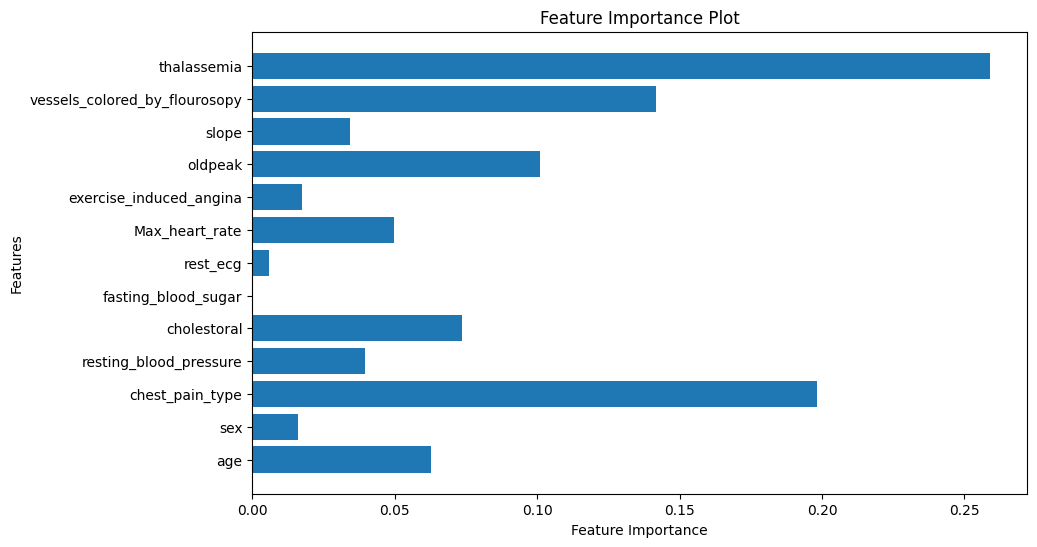

In [24]:
feature_importance = gb_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()

## Hyperparameter Tuning

In [35]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_best = best_model.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Akurasi: {accuracy_best}")

# Print the classification report
print(classification_report(y_test, y_pred_best))

Akurasi: 0.9853658536585366
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

